# CDK2: Metadatos
### Genera un archivo de metadatos de los cristales del pdb

In [1]:
# Librerías
import pypdb
import pandas as pd
import numpy as np
import csv
import pickle
from prody import *
from Bio import pairwise2

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Los metadatos se generan a partir de la lista de PDB IDs obtenida con un BLASTp a partir de la secuencia query P24941. Un archivo que guarda los datos del blast es leido y de él se carga la lista de PDB IDs.

In [2]:
# Secuencia de la CDK2 de UniProt
cdk2_P24941 = "MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL"

In [3]:
# Cargo los datos del alineamiento hecho con PRODY en el archivo Descarga_PDBs_CDK2.ipynb
blast_record = pickle.load(open('cdk2_blast_record.pkl', 'rb'))

pdbids = blast_record.getHits(percent_identity=95) # Devuelve un diccionario con cada proteína hit
len(pdbids) # 391 proteínas tienen un 95% de identidad con la secuencia de UNIPROT

# Lista de PDB IDs
pdbids_list = list(pdbids.keys()) # lista de pdb_ids de las estructuras de CDK2
len(pdbids_list)

391

In [4]:
pdbids_list[0:5]

['1fin', '1ckp', '1buh', '1dm2', '1di8']

### NOTA:
**Tener en cuenta que *pdbids_list* y *pdbids* están ordenados por su valor de identidad y no por orden alfabético.**  
Sin embargo, a partir de la creación de la tabla de metadatos y el modelado de las estructuras, los datos y archivos estarán ordenados por orden alfabético.

### Funciones extra
Empleo las siguientes dos funciones para obtener alienamientos correctos de la secuencia del pdb en relación con la secuencia de uniprot, y saber así el valor de covertura y el número de gaps en la estructura.

In [8]:
# Versión marzo 2018 *Anotar las modificaciones en esta versión y comentar lo pasado
def find_gaps(seq, r=1): # r es el número de residuos móviles al lado de la ventana del gap
    import re
    '''Encontrar el número e inicio y final de los gaps en el alineamiento'''
    seq_len = len(seq)
    gaps = list(re.finditer('[-]+', seq)) # todas las subsecuencias que tienen uno o más guiones
    num_gaps = len(gaps); gap_lengths = []
    gap_list = []; gap_window = []
    # Obtener el índice de inicio y final del gap
    for i , gap in enumerate(gaps, 1):
        start = gap.start() + 1
        end = gap.end()
        gap_lengths.append(end - start + 1)
        gap_list.append([start, end])
        end_right = end if end >= seq_len else end  + r
        start_right = start if start == 1 else start - r
        gap_window.append([start_right, end_right])
    return({"num_gaps": num_gaps, "gap_lengths":gap_lengths,
            "gap_list": gap_list, "gap_window": gap_window})

In [16]:
def get_seq_data(pdb_id, seq_TOTAL, struct_dir = './PDB_CDK2_chains/', tail_pdb = '_A.pdb'):
    '''Genera un alineamiento  partir de una estructura PDB y una secuencia de aminoácidos.'''
    structure = parsePDB(struct_dir + pdb_id + tail_pdb).getHierView()["A"]
    seq_query = structure.getSequence()
    alignment = pairwise2.align.globalxs(seq_query, seq_TOTAL, 
                                            -10, -1, gap_char='-',
                                        one_alignment_only = True)[0]
    seq_alg = alignment[0]

    covertura = len(seq_query) / len(cdk2_P24941) *100
    gaps = find_gaps(alignment[0])
    num_gaps = gaps["num_gaps"]
    gap_lengths = gaps["gap_lengths"]
    gap_list = gaps["gap_list"]

    # Debería retornar un tuple con 3 elementos
    return(seq_alg, covertura, gaps)

# Ejemplo
# get_seq_data('1e9h', cdk2_P24941)

## Descarga de los metadatos de los cristales
Para descargar los metadatos de los pdbs y posteriormente guardarlos en un archivo. Para ello se itera la lista de PDB IDs y se guardan los adtos en un diccionario.

### NOTA:
Justo antes de iniciar el loop pdbids_list es ordenada.

In [27]:
cdk2_crys_mtd = {} # Diccionario temporal para posteriormente guardar en un archivo de texto
import time
start = time.time()

#***** DESCOMENTAR para volver a ejectutar ****
# pdbids_list = ["aaaa"]

# Primero se crea el diccionario
pdbids_list.sort() # Lista ordenada alfanuméricamente 
for pdb in pdbids_list:
    '''Para obtener los metadatos de todos los cristales'''
    try:
        descrip_pdb = pypdb.describe_pdb(pdb)
        cristal = pypdb.get_entity_info(pdb)
        ligando = pypdb.get_ligands(pdb)['ligandInfo']
        secuencia = pdbids[pdb]
        seq_alg, covertura, gaps = get_seq_data(pdb, cdk2_P24941)
        if ligando != None:
            ligando = ligando['ligand']
            if isinstance(ligando, dict): 
                # Si me devuelve un dict significa que sólo hay un lig
                ligando = [ligando] # Anida el dict a una lista, tal como
                # ocurre cuando hay más de un ligando
            num_ligs = len(ligando)
            # Lista del nombre de los ligandos
            ligs_names = [ligando[mol]['@chemicalID'] for mol in range(num_ligs)]
        else:
            ligs_names = []
            num_ligs = 0
        cdk2_crys_mtd.update({pdb : {'describe_pdb': descrip_pdb, 'pdb_info': cristal, 'ligs': ligando, 
                                     'num_ligs': num_ligs, 'name_ligs': ligs_names,'seq': secuencia,
                                     'seq_alg': seq_alg, 'covertura': covertura, 'gaps': gaps}})
    except Exception as e:
        print(e + ": Error con " + pdb)
    # print(pdb)

        # Finalmente el diccionario generado posee un diccionario para cada clave pdb,
        # que subsecuentemente posee cinco entradas: pdb_info, ligs, ligs_names, num_ligs, seq
    
end = time.time()
print(end - start)
print(len(cdk2_crys_mtd))

@> 2230 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2262 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2346 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2260 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2223 atoms and 1 coordinate set(s) we

@> 2329 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2228 atoms and 1 coordinate set(s) we

@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2325 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) we

203.8323302268982
391


### Para guardar y leer el archivo de metadatos

Para este punto se han descargado los 391 cristales de cdk2 disponibles. sin embargo, de los 391 iniciales, se descartarán **5ang** por tener una covertura menor al 50%. Adicionalmente, para la Tabla de datos de los cristales con los que se trabajarán se descartarán también 3 estructuras más: **4ek6, 6ath, 5uq3**.

In [28]:
len(cdk2_crys_mtd)

391

In [2]:
## GUARDAR
# Versión JSON
import json
#json.dump(cdk2_crys_mtd, open("MTDATA_CDK2_391_crys.json",'w'))

## LEER
cdk2_crys_mtd = json.load(open("MTDATA_CDK2_391_crys.json"))
len(cdk2_crys_mtd)

391

# Creación de la tabla de metadatos
### Funciones para generar la tabla de datos

In [3]:
# PDB_ID, Título, #Entidades, #Cadenas, Cadena, Covertura, #Gaps, ListaGaps, #residuos, Resulucion, método, #Ligs, IDs Ligs, 
# Nombres Ligs, Lig más grande, Peso Lig más grande
def get_data_rows(pdb_entry):
    x = pdb_entry
    d = x['describe_pdb']
    s = x['seq']
    l = x['ligs']

    dic = {"PDB_ID": d['structureId'].lower(),
          "Title": d['title'].lower(),
          "Entities": d['nr_entities'],
          "ChainID": s['chain_id'],
          "Identity": s['identity'],
          "Coverage": x['covertura'],
          "NumGaps": x['gaps']['num_gaps'],
          "GapLen": x['gaps']['gap_lengths'],
          "GapPos": x['gaps']['gap_list'],
          #"NumResidues": ,
          "Resolution": d['resolution'],
          "Date": d['release_date'],
          "NumLigs": x['num_ligs'], 
          "NameLigs": x['name_ligs'], ##
          }
    return(pd.Series(dic))

def get_mtd_table(dic):
    df = pd.DataFrame()
    for pdb_id in dic.keys():
        row = get_data_rows(dic[pdb_id])
        df = df.append(row, ignore_index=True)
    return(df)

### Se genera, ORDENA y se descartan 4 PDBIs del DataFrame
Se crea la tabla de los metadatos con las 387 PDBis, lo que implicó descartar las filas para **5ang, 4ek6, 6ath y 5uq3**. Después se ordena la tabla en orden alfanumérico.

In [4]:
# Se genera el dataframe
df_cdk2 = get_mtd_table(cdk2_crys_mtd).sort_values("PDB_ID")
print("La tabla de datos tiene registradas", str(len(df_cdk2)), "estructuras.")

# Removemos las estructuras que no servirán para continuar el análisis
droped_pdb_ids = ["5ang", "4ek6", "6ath", "5uq3",
                 "1jsu", "5mhq"]
df_cdk2 = df_cdk2.loc[ ~df_cdk2["PDB_ID"].isin(droped_pdb_ids) ]
print("La NUEVA tabla de datos tiene registradas", str(len(df_cdk2)), "estructuras.")

# Reordenando la tabla
df_cdk2 = df_cdk2.reset_index()

# Se reordenan las columnas
df_cdk2 = df_cdk2[['PDB_ID', 'Title','Date', 'Entities', 'ChainID','Resolution', 
         'Identity', 'Coverage', 'NumGaps', 'GapLen', 'GapPos',
         'NumLigs', 'NameLigs']]

df_cdk2.head()

La tabla de datos tiene registradas 391 estructuras.
La NUEVA tabla de datos tiene registradas 385 estructuras.


,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
0,1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,[STU]
1,1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"
2,1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"
3,1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[]
4,1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"[EDO, PVB]"


In [5]:
# Lista de columnas del dataframe
', '.join( df_cdk2.columns.tolist() )

'PDB_ID, Title, Date, Entities, ChainID, Resolution, Identity, Coverage, NumGaps, GapLen, GapPos, NumLigs, NameLigs'

#### Se guarda la tabla en archivo csv

In [6]:
df_cdk2.to_csv("./TABLA_MTDATA_CDK2_385_crys.csv")

## Nube de palabras de los títulos de metadatos

In [34]:
# import numpy as np
# import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

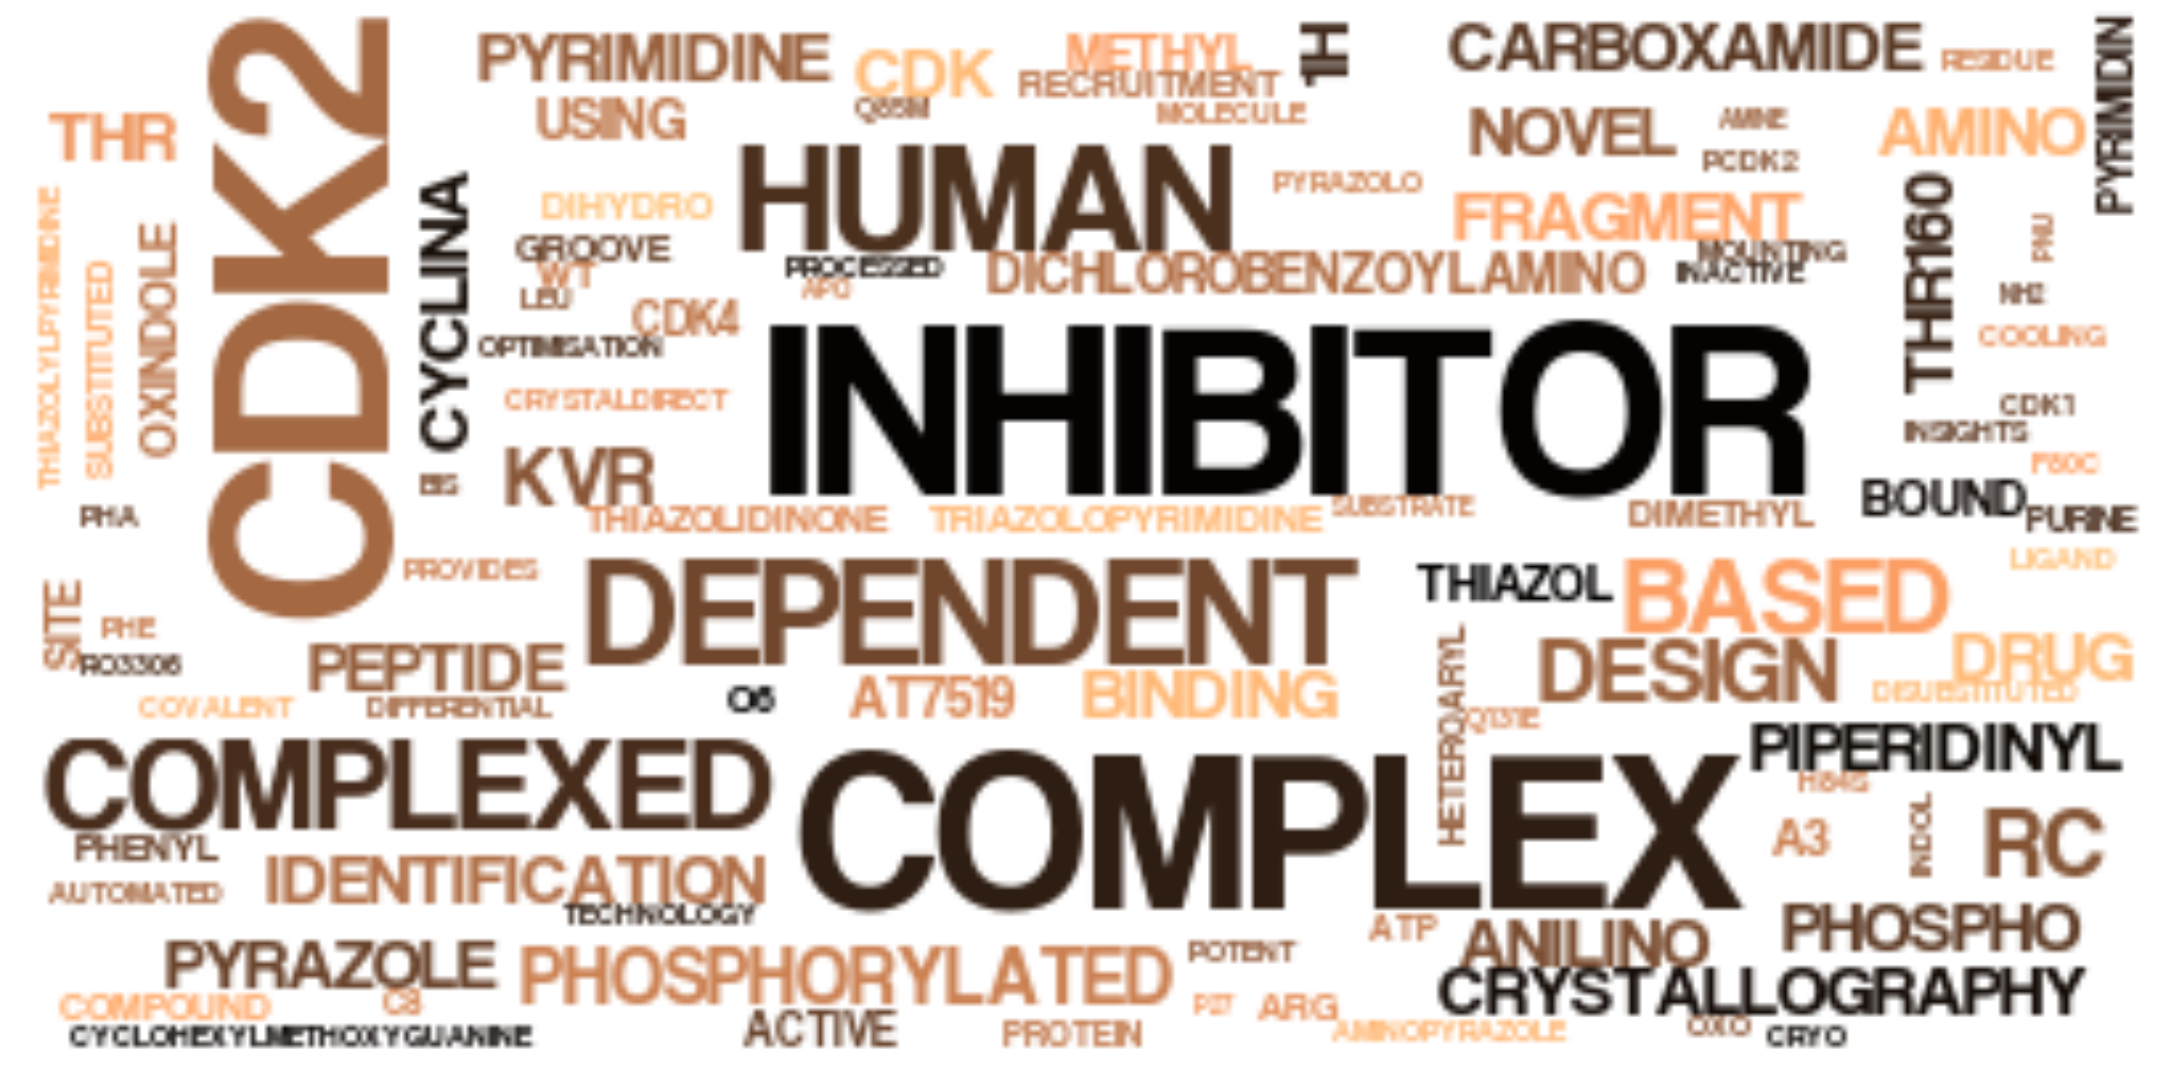

In [36]:
text = " ".join(titulo for titulo in df_cdk2.Title)
text = text.replace('-', ' ').upper()

stopwords = set(STOPWORDS)
stopwords.update([ "cyclin", "structure", "kinase", "ray", "crystal", "yl"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, collocations=False, min_font_size=4,
                      contour_width=20, colormap = "copper", random_state=15,
                      max_words=100, background_color="white", font_path='./coolvetica.ttf').generate(text)

plt.figure(figsize=(38,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
# Número de ligandos

import itertools
# Lista de nombre de todos los ligandos
ligFull_list = list( itertools.chain.from_iterable( df_cdk2.NameLigs ) )

# Lista de ligandos únicos
ligAll_list = list(set(ligFull_list))

print('Número de ligandos de CDK2: ', len(ligAll_list))

Número de ligandos de CDK2:  347


### Histogramas

In [38]:
### Tabla de datos
df_cdk2.head(5)

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
0,1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,[STU]
1,1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"
2,1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"
3,1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[]
4,1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"[EDO, PVB]"


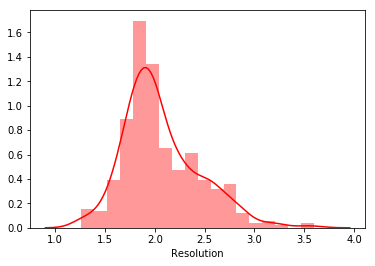

In [87]:
import seaborn as sns

df_cdk2["Resolution"] = df_cdk2["Resolution"].astype(float)
sns.distplot( df_cdk2["Resolution"] , color="red", label="Sepal Length")


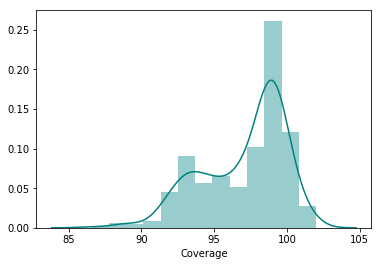

In [91]:
sns.distplot( df_cdk2["Coverage"] , color="teal", label="Sepal Length")

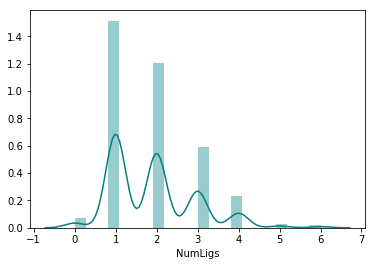

In [92]:
sns.distplot( df_cdk2["NumLigs"] , color="teal", label="Sepal Length")

### Gráfica de covertura

In [49]:
## LEER
cdk2_crys_mtd = json.load(open("MTDATA_CDK2_391_crys.json"))
len(cdk2_crys_mtd)

391

In [194]:
import re

pdbids_list = list(cdk2_crys_mtd.keys()) # lista de pdb_ids de las estructuras de CDK2
len(pdbids_list)

f= open("./coverturas_seq_cdk2.dat","w+")

residuos = ','.join(map(str, list(range(1, 299, 1))))

f.write(residuos + "\n")
for pdb_id in pdbids_list:
    # Obten el alineamiento del metadatos del 0 al 297
    text_alg = cdk2_crys_mtd[pdb_id]["seq_alg"][0:298]

    # Convierte a valoresde 1 y 0 (-)
    a = re.sub(r'[A-Z]', '1', text_alg)
    b = re.sub(r'-', '0', a)
    line= ','.join(b)
    f.write(line + "\n")
f.close()

#### Se carga el .dat como csv en pandas

In [195]:
import pandas as pd
seq_coverage = pd.read_csv("./coverturas_seq_cdk2.dat", header=0)
seq_coverage.head()

,1,2,3,4,5,6,7,8,9,10,...,289,290,291,292,293,294,295,296,297,298
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [208]:
proporcion = pd.DataFrame(seq_coverage.sum()/390)
proporcion = proporcion.transpose()


In [215]:
proporcion.transpose().to_csv("./coverturas_seq_cdk2.chimera")


<Figure size 432x288 with 0 Axes>

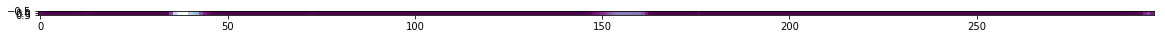

In [168]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(20,20))
heatplot = ax.imshow(proporcion, cmap='BuPu', aspect="equal")

tick_spacing = 1

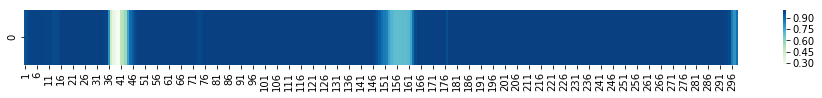

In [203]:
import seaborn as sns
fig = plt.figure(figsize=(16,1))
r = sns.heatmap(proporcion, cmap='GnBu')
r

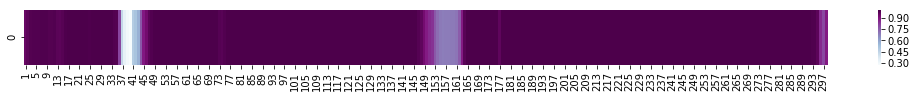

In [172]:
import seaborn as sns
fig = plt.figure(figsize=(18,1))
r = sns.heatmap(proporcion, cmap='BuPpython cluster_py3_RICCI.py -i indexMapToFrames.csv -n 5 -m POVME_Tanimoto_matrix_colored.csv -t res_:../../cdk2_crys_ensamble_387_TOTAL_RICCI_alg.pdbu')
r

In [7]:
# ¿cuantas entidades y cadenas tiene cada proteína?

cdk2_cry_chains = {}

for pdb in cdk2_pdb_id:
    entidades = d2[pdb]["pdb_info"]['Entity']
    if isinstance(entidades, dict): # Si es diccionario tendrá solo una identidad
        num_ents = 1
        num_chains_cdk2 = len(entidades['Chain'])
    else: #Entidades será una lista de entidades
        num_ents = len(entidades)
        num_chains_cdk2 = len(entidades[0]['Chain']) # Se espera que CDK2 sea la primera entidad
    cdk2_cry_chains.update({pdb: {"Enidades": num_ents, "Cadenas_CDK2": num_chains_cdk2}})

In [8]:
cdk2_cry_chains

{'1AQ1': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1B38': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1B39': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1BUH': {'Enidades': 2, 'Cadenas_CDK2': 1},
 '1CKP': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1DI8': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1DM2': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1E1V': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1E1X': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1E9H': {'Enidades': 2, 'Cadenas_CDK2': 2},
 '1F5Q': {'Enidades': 2, 'Cadenas_CDK2': 2},
 '1FIN': {'Enidades': 2, 'Cadenas_CDK2': 2},
 '1FQ1': {'Enidades': 2, 'Cadenas_CDK2': 1},
 '1FVT': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1FVV': {'Enidades': 2, 'Cadenas_CDK2': 2},
 '1G5S': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1GIH': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1GII': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1GIJ': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1GY3': {'Enidades': 3, 'Cadenas_CDK2': 2},
 '1GZ8': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1H00': {'Enidades': 1, 'Cadenas_CDK2': 1},
 '1H01': {

### Descarga de los cristales PDB

## Análisis de los cristales
De todos los critales, CSAR indica que el ligando CS262 es de los de mejor afinidad y pertenece al PDB 4FKW. Binding database reporta a la estaurosporina (STU) como uno de los mejores inhibidores de cinasas, y de gran afinidad a CDK2. El PDB del complejo CDK2-STU es 1AQ1.

Por inspección visual se confirma que los ligandos STU y todos los de CSAR se unen al sitio activo de la proteína.
Tomando en cuenta estos ligandos, voy a proceder a definir el pocket (los aminoácidos) para poder efectuar el clustering.

**Pocket (4FKW y su ligando a 7 A):** 8-19, 30-33, 64-65, 79-90, 129-134, 143-146

In [57]:
#import pytraj as pt
import nglview as nv
resid 8 to 19 30 to 33 64 65 79 to 90 129 to 134 143 to 146

ModuleNotFoundError: No module named 'nglview'

In [5]:
import ipywidgets
ipywidgets.Text("hello")

Text(value='hello')

In [ ]:
Preguntas
Cuantos ligandos tiene cada un
Que nombre tiene
En total cuantos ligandos puede haber en todos los complejos
Cuantas cadenas tiene
cuantos residuos tiene

Guardar en archivos json, para cas identificador un diccionario andado
Primero, datos de la proteina y datos del ligando

debe guardar el pdb, y guardar una entrada en forma de  lista para el pdb en un archivo json

[{'@chemicalID': 'ACE',
  '@molecularWeight': '44.053',
  '@structureId': '1B38',
  '@type': 'non-polymer',
  'InChI': 'InChI=1S/C2H4O/c1-2-3/h2H,1H3',
  'InChIKey': 'IKHGUXGNUITLKF-UHFFFAOYSA-N',
  'chemicalName': 'ACETYL GROUP',
  'formula': 'C2 H4 O',
  'smiles': 'CC=O'},
 {'@chemicalID': 'ATP',
  '@molecularWeight': '507.181',
  '@structureId': '1B38',
  '@type': 'non-polymer',
  'InChI': 'InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(3-14-5)10-7(17)6(16)4(26-10)1-25-30(21,22)28-31(23,24)27-29(18,19)20/h2-4,6-7,10,16-17H,1H2,(H,21,22)(H,23,24)(H2,11,12,13)(H2,18,19,20)/t4-,6-,7-,10-/m1/s1',
  'InChIKey': 'ZKHQWZAMYRWXGA-KQYNXXCUSA-N',
  'chemicalName': "ADENOSINE-5'-TRIPHOSPHATE",
  'formula': 'C10 H16 N5 O13 P3',
  'smiles': 'c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)O)O)N'},
 {'@chemicalID': 'MG',
  '@molecularWeight': '24.305',
  '@structureId': '1B38',
  '@type': 'non-polymer',
  'InChI': 'InChI=1S/Mg/q+2',
  'InChIKey': 'JLVVSXFLKOJNIY

In [32]:
pd.DataFrame(x["ligandInfo"])

,ligand
@chemicalID,STU
@molecularWeight,466.531
@structureId,1AQ1
@type,non-polymer
InChI,InChI=1S/C28H26N4O3/c1-28-26(34-3)17(29-2)12-2...
InChIKey,HKSZLNNOFSGOKW-FYTWVXJKSA-N
chemicalName,STAUROSPORINE
formula,C28 H26 N4 O3
smiles,C[C@@]12[C@@H]([C@@H](C[C@@H](O1)n3c4ccccc4c5c...


In [13]:
file = open("5ANE.pdb","w")
file.write(pypdb.get_pdb_file('5ANE'))
file.close() 

In [15]:
cdk2_pdb_id = ["1AQ1","1B38","1B39","1BUH","1CKP","1DI8","1DM2","1E1V","1E1X","1E9H","1F5Q","1FIN","1FQ1",
               "1FVT","1FVV","1G5S","1GIH","1GII","1GIJ","1GY3","1GZ8","1H00","1H01","1H07","1H08","1H0V",
               "1H0W","1H1P","1H1Q","1H1R","1H1S","1H24","1H25","1H26","1H27","1H28","1HCK","1HCL","1JST",
               "1JSU","1JSV","1JVP","1KE5","1KE6","1KE7","1KE8","1KE9","1OGU","1OI9","1OIQ","1OIR","1OIT",
               "1OIU","1OIY","1OKV","1OKW","1OL1","1OL2","1P2A","1P5E","1PF8","1PKD","1PW2","1PXI","1PXJ",
               "1PXK","1PXL","1PXM","1PXN","1PXO","1PXP","1PYE","1QMZ","1R78","1URC","1URW","1V1K","1VYW",
               "1VYZ","1W0X","1W8C","1W98","1WCC","1Y8Y","1Y91","1YKR","2A0C","2A4L","2B52","2B53","2B54",
               "2B55","2BHE","2BHH","2BKZ","2BPM","2BTR","2BTS","2C4G","2C5N","2C5O","2C5V","2C5X","2C5Y",
               "2C68","2C69","2C6I","2C6K","2C6L","2C6M","2C6O","2C6T","2CCH","2CCI","2CJM","2CLX","2DS1",
               "2DUV","2EXM","2FVD","2G9X","2I40","2IW6","2IW8","2IW9","2J9M","2JGZ","2R3F","2R3G","2R3H",
               "2R3I","2R3J","2R3K","2R3L","2R3M","2R3N","2R3O","2R3P","2R3Q","2R3R","2R64","2UUE","2UZB",
               "2UZD","2UZE","2UZL","2UZN","2UZO","2V0D","2V22","2VTA","2VTH","2VTI","2VTJ","2VTL","2VTM",
               "2VTN","2VTO","2VTP","2VTQ","2VTR","2VTS","2VTT","2VU3","2VV9","2W05","2W06","2W17","2W1H",
               "2WEV","2WFY","2WHB","2WIH","2WIP","2WMA","2WMB","2WPA","2WXV","2X1N","2XMY","2XNB","3BHT",
               "3BHU","3BHV","3DDP","3DDQ","3DOG","3EID","3EJ1","3EOC","3EZR","3EZV","3F5X","3FZ1","3IG7",
               "3IGG","3LE6","3LFN","3LFQ","3LFS","3MY5","3NS9","3PJ8","3PXF","3PXQ","3PXR","3PXY","3PXZ",
               "3PY0","3PY1","3QHR","3QHW","3QL8","3QQF","3QQG","3QQH","3QQJ","3QQK","3QQL","3QRT","3QRU",
               "3QTQ","3QTR","3QTS","3QTU","3QTW","3QTX","3QTZ","3QU0","3QWJ","3QWK","3QX2","3QX4","3QXO",
               "3QXP","3QZF","3QZG","3QZH","3QZI","3R1Q","3R1S","3R1Y","3R28","3R6X","3R71","3R73","3R7E",
               "3R7I","3R7U","3R7V","3R7Y","3R83","3R8L","3R8M","3R8P","3R8U","3R8V","3R8Z","3R9D","3R9H",
               "3R9N","3R9O","3RAH","3RAI","3RAK","3RAL","3RJC","3RK5","3RK7","3RK9","3RKB","3RM6","3RM7",
               "3RMF","3RNI","3ROY","3RPO","3RPR","3RPV","3RPY","3RZB","3S00","3S0O","3S1H","3S2P","3SQQ",
               "3SW4","3SW7","3TI1","3TIY","3TIZ","3TNW","3ULI","3UNJ","3UNK","3WBL","4ACM","4BCK","4BCM",
               "4BCN","4BCO","4BCP","4BCQ","4BGH","4BZD","4CFM","4CFN","4CFU","4CFV","4CFW","4CFX","4D1X",
               "4D1Z","4EK3","4EK4","4EK5","4EK6","4EK8","4EOI","4EOJ","4EOK","4EOL","4EOM","4EON","4EOO",
               "4EOP","4EOQ","4EOR","4EOS","4ERW","4EZ3","4EZ7","4FKG","4FKI","4FKJ","4FKL","4FKO","4FKP",
               "4FKQ","4FKR","4FKS","4FKT","4FKU","4FKV","4FKW","4FX3","4GCJ","4I3Z","4II5","4KD1","4LYN",
               "4NJ3","4RJ3","5A14","5AND","5ANE","5ANG","5ANI","5ANJ","5ANK","5ANO","5CYI","5D1J","5FP5",
               "5FP6","5IEV","5IEX","5IEY","5IF1","5JQ5","5JQ8","5K4J","5L2W","5LMK","5MHQ","5NEV","5UQ1",
               "5UQ2","5UQ3"
]

In [16]:
for pdb_id in cdk2_pdb_id:
    pdb_data = pypdb.get_ligands(pdb_id)
    if pdb_data['ligandInfo'] == None:
        print(pdb_id)

1BUH
1HCL
1PW2
5ANO
5IF1
5UQ1
5UQ2
5UQ3
